# Notebook 04: Move Network Analysis

**Objective**: Analyze special move relationships and patterns in the Digimon Knowledge Graph.

This notebook explores:
- Move statistics and distribution
- Move-based clustering and similarity
- Move evolution and inheritance patterns
- Network analysis of move relationships

---

## 1. Setup and Imports

In [24]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Custom utilities
from utils import (
    Neo4jConnector,
    plot_network_interactive, plot_network_static,
    plot_heatmap, save_figure,
    calculate_basic_metrics, find_cliques,
    TYPE_COLORS, LEVEL_COLORS
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set notebook name for organized output
notebook_name = "04_move_network_analysis"

print("Environment setup complete!")

Environment setup complete!


## 2. Load Move Data

In [25]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Get all Digimon data
digimon_df = conn.get_all_digimon()
print(f"Loaded {len(digimon_df)} Digimon")

# Get move data
moves_df = conn.get_digimon_moves()
print(f"\nLoaded {len(moves_df)} Digimon-Move relationships")
print(f"Unique moves: {moves_df['move'].nunique()}")
print(f"Digimon with moves: {moves_df['digimon'].nunique()}")

Connected to Neo4j database
Loaded 1258 Digimon

Loaded 2433 Digimon-Move relationships
Unique moves: 2133
Digimon with moves: 1242


In [26]:
# Display sample move data
print("Sample move data:")
moves_df.head(10)

Sample move data:


,digimon,move,move_jp
0,ABBADOMON,Garliteness,None
1,ABBADOMON,Gaze Eraser,None
2,ABBADOMON,White Liner,None
3,ABBADOMONCORE,Bingelado,None
4,ABBADOMONCORE,Death Charge,None
5,ABBADOMONCORE,Eclipse Noon,None
6,ABBADOMONCORE,Gaze Eraser,None
7,ACHILLESMON,Anemone Dalmènos,None
8,ACHILLESMON,Asteroidis,None
9,ACHILLESMON,Ronhi Adistact,None


## 3. Move Statistics

In [27]:
# Move frequency distribution
move_counts = moves_df['move'].value_counts()

print("=== MOVE FREQUENCY STATISTICS ===")
print(f"Total unique moves: {len(move_counts)}")
print(f"Average Digimon per move: {move_counts.mean():.2f}")
print(f"Median Digimon per move: {move_counts.median():.0f}")
print(f"Most common move: {move_counts.index[0]} ({move_counts.iloc[0]} Digimon)")
print(f"Rarest moves: {(move_counts == 1).sum()} moves used by only 1 Digimon")

print("\nTop 15 most common moves:")
for move, count in move_counts.head(15).items():
    print(f"  {move}: {count} Digimon")

=== MOVE FREQUENCY STATISTICS ===
Total unique moves: 2133
Average Digimon per move: 1.14
Median Digimon per move: 1
Most common move: Acid foam (13 Digimon)
Rarest moves: 1909 moves used by only 1 Digimon

Top 15 most common moves:
  Acid foam: 13 Digimon
  Three Victorise: 6 Digimon
  Petit Twister: 5 Digimon
  Mega Flame: 5 Digimon
  Baby Flame: 5 Digimon
  Burning Star Crusher: 5 Digimon
  Giga Destroyer: 5 Digimon
  Fusion: 4 Digimon
  Kaiser Nail: 4 Digimon
  Exhaust Flame: 4 Digimon
  Hellfire: 4 Digimon
  Plasma Blade: 4 Digimon
  Garuru Canon: 4 Digimon
  Poop throw: 4 Digimon
  Grey Sword: 4 Digimon


In [28]:
# Moves per Digimon statistics
digimon_move_counts = moves_df.groupby('digimon')['move'].count()

print("\n=== MOVES PER DIGIMON STATISTICS ===")
print(f"Average moves per Digimon: {digimon_move_counts.mean():.2f}")
print(f"Median moves per Digimon: {digimon_move_counts.median():.0f}")
print(f"Max moves: {digimon_move_counts.max()} (by {digimon_move_counts.idxmax()})")
print(f"Min moves: {digimon_move_counts.min()}")

# Distribution of move counts
move_count_dist = digimon_move_counts.value_counts().sort_index()
print("\nDistribution of move counts:")
for num_moves, count in move_count_dist.head(10).items():
    print(f"  {num_moves} moves: {count} Digimon")


=== MOVES PER DIGIMON STATISTICS ===
Average moves per Digimon: 1.96
Median moves per Digimon: 2
Max moves: 8 (by HI-VISIONMONITAMON)
Min moves: 1

Distribution of move counts:
  1 moves: 426 Digimon
  2 moves: 512 Digimon
  3 moves: 261 Digimon
  4 moves: 27 Digimon
  5 moves: 7 Digimon
  6 moves: 7 Digimon
  7 moves: 1 Digimon
  8 moves: 1 Digimon


In [29]:
# Move diversity by type and level
# Merge with Digimon data
moves_with_info = moves_df.merge(
    digimon_df[['name_en', 'type', 'level', 'attribute']], 
    left_on='digimon', 
    right_on='name_en'
)

# Move diversity by type
type_move_diversity = moves_with_info.groupby('type')['move'].nunique().sort_values(ascending=False)
print("\n=== MOVE DIVERSITY BY TYPE (Top 15) ===")
for type_name, unique_moves in type_move_diversity.head(15).items():
    type_count = digimon_df[digimon_df['type'] == type_name].shape[0]
    print(f"  {type_name}: {unique_moves} unique moves ({type_count} Digimon)")

# Move diversity by level
level_move_diversity = moves_with_info.groupby('level')['move'].nunique()
level_order = ['Baby', 'In-Training', 'Rookie', 'Champion', 'Ultimate', 'Mega', 'Ultra']
level_move_diversity = level_move_diversity.reindex(level_order, fill_value=0)

print("\n=== MOVE DIVERSITY BY LEVEL ===")
for level, unique_moves in level_move_diversity.items():
    level_count = digimon_df[digimon_df['level'] == level].shape[0]
    print(f"  {level}: {unique_moves} unique moves ({level_count} Digimon)")


=== MOVE DIVERSITY BY TYPE (Top 15) ===
  cyborg Type: 182 unique moves (98 Digimon)
  Puppet Type: 99 unique moves (48 Digimon)
  God Type: 94 unique moves (38 Digimon)
  mutation Type: 93 unique moves (56 Digimon)
  Demon Type: 75 unique moves (39 Digimon)
  Beastman Type: 67 unique moves (38 Digimon)
  beast Type: 66 unique moves (39 Digimon)
  Machine Type: 66 unique moves (41 Digimon)
  Holy Knight Type: 64 unique moves (35 Digimon)
  Dragon Type: 62 unique moves (27 Digimon)
  insect Type: 59 unique moves (41 Digimon)
  fairy Type: 54 unique moves (24 Digimon)
  Demon Beast Type: 47 unique moves (25 Digimon)
  Holy Beast Type: 45 unique moves (31 Digimon)
  Undead Type: 42 unique moves (22 Digimon)

=== MOVE DIVERSITY BY LEVEL ===
  Baby: 0 unique moves (0 Digimon)
  In-Training: 0 unique moves (0 Digimon)
  Rookie: 222 unique moves (146 Digimon)
  Champion: 388 unique moves (243 Digimon)
  Ultimate: 450 unique moves (248 Digimon)
  Mega: 653 unique moves (328 Digimon)
  Ultra: 

## 4. Move-based Clustering

In [30]:
# Create Digimon-Move matrix for similarity analysis
digimon_move_matrix = moves_df.pivot_table(
    index='digimon', 
    columns='move', 
    values='move',
    aggfunc='count',
    fill_value=0
)

# Convert to binary (has move or not)
digimon_move_binary = (digimon_move_matrix > 0).astype(int)

print(f"Digimon-Move matrix shape: {digimon_move_binary.shape}")
print(f"Sparsity: {(digimon_move_binary == 0).sum().sum() / (digimon_move_binary.shape[0] * digimon_move_binary.shape[1]) * 100:.2f}%")

Digimon-Move matrix shape: (1242, 2133)
Sparsity: 100.00%


In [31]:
# Calculate Jaccard similarity between Digimon based on moves
# Sample for computational efficiency
sample_size = min(100, len(digimon_move_binary))
sample_digimon = digimon_move_binary.sample(n=sample_size, random_state=42)

# Calculate pairwise Jaccard distances
jaccard_distances = pdist(sample_digimon.values, metric='jaccard')
jaccard_similarity = 1 - squareform(jaccard_distances)

# Create similarity DataFrame
similarity_df = pd.DataFrame(
    jaccard_similarity,
    index=sample_digimon.index,
    columns=sample_digimon.index
)

print(f"Calculated Jaccard similarity for {sample_size} Digimon")

# Find most similar pairs
similarity_upper = similarity_df.where(
    np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
)
similar_pairs = similarity_upper.stack().sort_values(ascending=False)

print("\n=== MOST SIMILAR DIGIMON (by moves) ===")
for (dig1, dig2), similarity in similar_pairs.head(10).items():
    shared_moves = set(moves_df[moves_df['digimon'] == dig1]['move']) & \
                   set(moves_df[moves_df['digimon'] == dig2]['move'])
    print(f"{dig1} - {dig2}: {similarity:.3f} similarity ({len(shared_moves)} shared moves)")

Calculated Jaccard similarity for 100 Digimon

=== MOST SIMILAR DIGIMON (by moves) ===
PUSURIMON - SHINEGREYMON： RUINMODE: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - ARKADIMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - KABUTERIMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - CALAMARAMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - KABUKIMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - LEOMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - HEXEBLAUMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - GODDRAMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - DOMINIMON: 1.000 similarity (0 shared moves)
MASTERTYRANOMON - DOGMON: 1.000 similarity (0 shared moves)


Saved: ../results/04_move_network_analysis/figures/digimon_move_dendrogram.png
Saved: ../results/04_move_network_analysis/figures/digimon_move_dendrogram.svg
Saved: ../results/04_move_network_analysis/figures/digimon_move_dendrogram.pdf


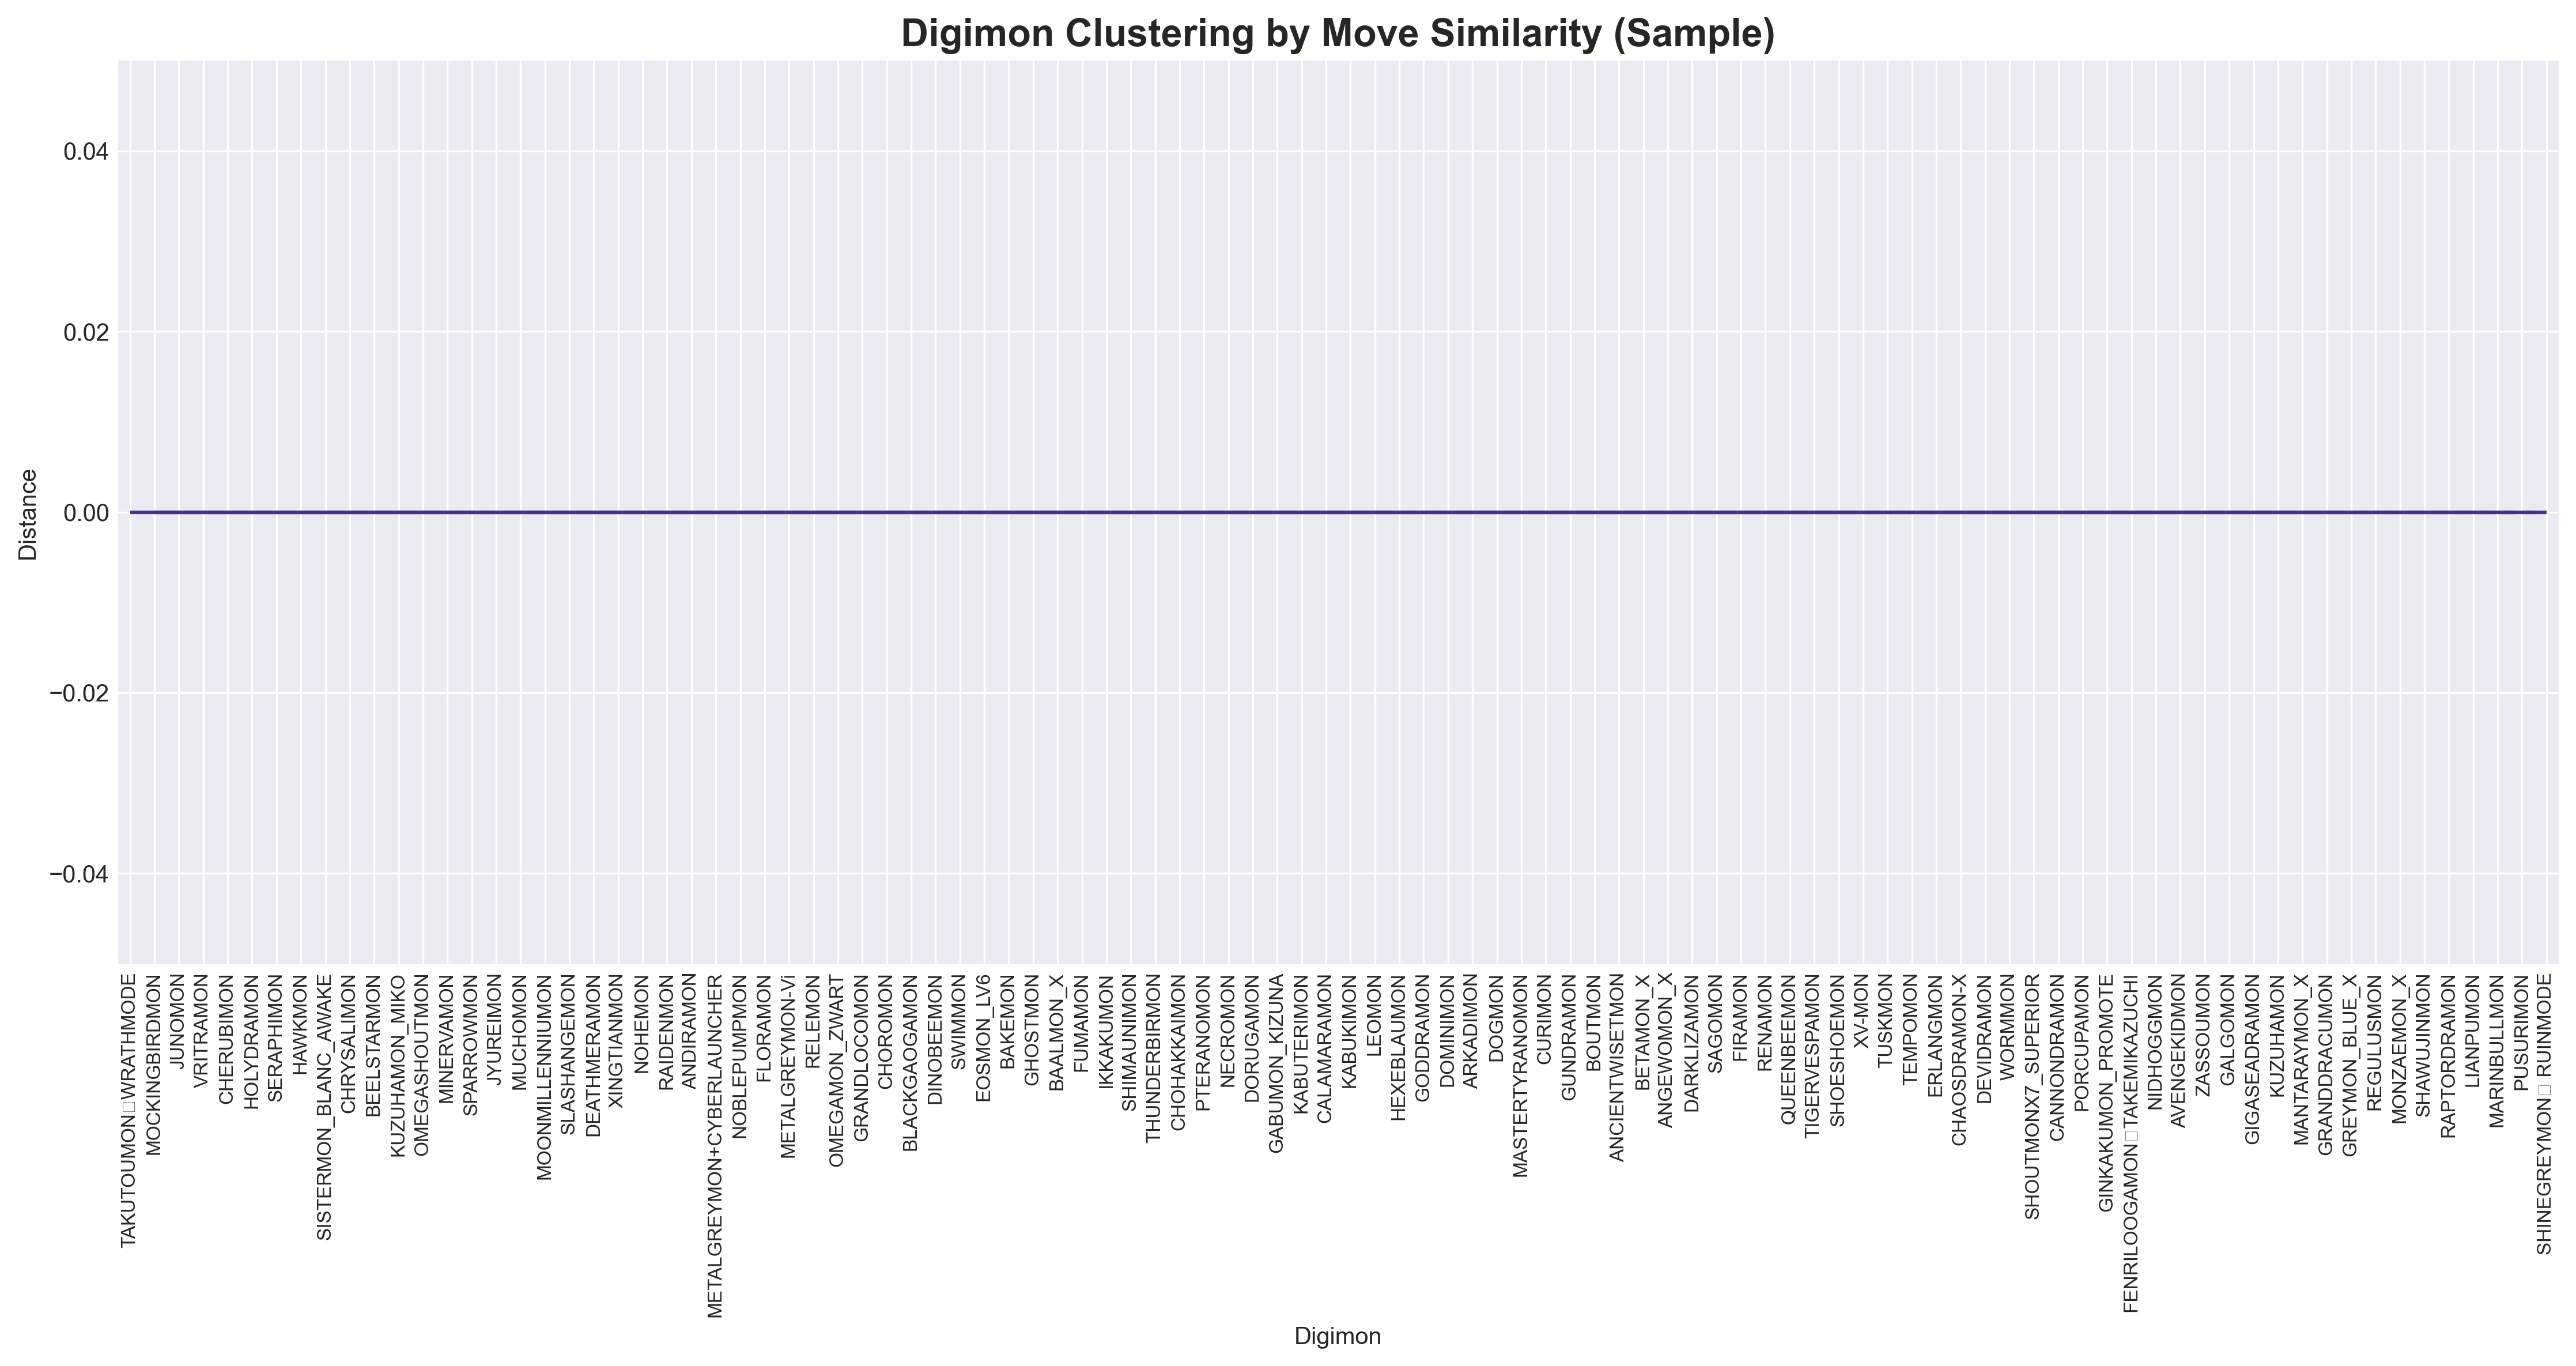


=== MOVE-BASED CLUSTERS ===

Cluster 1 (96 members):
  Members: PUSURIMON, SHINEGREYMON： RUINMODE, MARINBULLMON, LIANPUMON, RAPTORDRAMON...

Cluster 2 (1 members):
  Members: TAKUTOUMON：WRATHMODE
  Characteristic moves:
    - Bishamon Eight Pole Annihilation: 100.0% of cluster
    - Dragon Seng Ranshot: 100.0% of cluster

Cluster 3 (1 members):
  Members: MOCKINGBIRDMON
  Characteristic moves:
    - Iron inhaler: 100.0% of cluster
    - TriAirbots: 100.0% of cluster

Cluster 4 (1 members):
  Members: JUNOMON
  Characteristic moves:
    - Grace Lance: 100.0% of cluster
    - Love Basket: 100.0% of cluster
    - Needle hive: 100.0% of cluster

Cluster 5 (1 members):
  Members: VRITRAMON
  Characteristic moves:
    - Corona Blaster: 100.0% of cluster
    - Flame Storm: 100.0% of cluster


In [32]:
# Hierarchical clustering based on moves
linkage_matrix = linkage(jaccard_distances, method='ward')

# Create dendrogram
fig, ax = plt.subplots(figsize=(15, 8))
dendrogram(linkage_matrix, labels=sample_digimon.index.tolist(), 
           leaf_rotation=90, leaf_font_size=8, ax=ax)
ax.set_title('Digimon Clustering by Move Similarity (Sample)', fontsize=16, fontweight='bold')
ax.set_xlabel('Digimon')
ax.set_ylabel('Distance')
plt.tight_layout()
save_figure(fig, "digimon_move_dendrogram", notebook_name=notebook_name)
plt.show()

# Extract clusters
n_clusters = 5
clusters = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = clusters.fit_predict(1 - jaccard_similarity)

# Analyze clusters
cluster_df = pd.DataFrame({
    'digimon': sample_digimon.index,
    'cluster': cluster_labels
})

print(f"\n=== MOVE-BASED CLUSTERS ===")
for cluster_id in range(n_clusters):
    cluster_members = cluster_df[cluster_df['cluster'] == cluster_id]['digimon'].tolist()
    print(f"\nCluster {cluster_id + 1} ({len(cluster_members)} members):")
    print(f"  Members: {', '.join(cluster_members[:5])}{'...' if len(cluster_members) > 5 else ''}")
    
    # Find characteristic moves for this cluster
    cluster_moves = moves_df[moves_df['digimon'].isin(cluster_members)]['move'].value_counts()
    cluster_move_pct = cluster_moves / len(cluster_members)
    characteristic_moves = cluster_move_pct[cluster_move_pct > 0.5].head(5)
    
    if len(characteristic_moves) > 0:
        print(f"  Characteristic moves:")
        for move, pct in characteristic_moves.items():
            print(f"    - {move}: {pct:.1%} of cluster")

## 5. Move Evolution Analysis

In [33]:
# Get evolution data
evolution_data = conn.get_evolution_chains()
evolution_df = pd.DataFrame(evolution_data)

# Analyze move inheritance through evolution
move_inheritance = []

for _, evo in evolution_df.iterrows():
    from_digimon = evo['from_digimon']
    to_digimon = evo['to_digimon']
    
    # Get moves for both Digimon
    from_moves = set(moves_df[moves_df['digimon'] == from_digimon]['move'])
    to_moves = set(moves_df[moves_df['digimon'] == to_digimon]['move'])
    
    if from_moves and to_moves:
        inherited_moves = from_moves & to_moves
        new_moves = to_moves - from_moves
        lost_moves = from_moves - to_moves
        
        move_inheritance.append({
            'from_digimon': from_digimon,
            'to_digimon': to_digimon,
            'total_from_moves': len(from_moves),
            'total_to_moves': len(to_moves),
            'inherited_moves': len(inherited_moves),
            'new_moves': len(new_moves),
            'lost_moves': len(lost_moves),
            'inheritance_rate': len(inherited_moves) / len(from_moves) if from_moves else 0
        })

inheritance_df = pd.DataFrame(move_inheritance)

print("=== MOVE EVOLUTION PATTERNS ===")
print(f"Evolution pairs analyzed: {len(inheritance_df)}")
print(f"\nAverage move inheritance rate: {inheritance_df['inheritance_rate'].mean():.2%}")
print(f"Average new moves gained: {inheritance_df['new_moves'].mean():.1f}")
print(f"Average moves lost: {inheritance_df['lost_moves'].mean():.1f}")

# Examples of high inheritance
high_inheritance = inheritance_df.nlargest(10, 'inheritance_rate')
print("\nEvolutions with highest move inheritance:")
for _, row in high_inheritance.iterrows():
    if row['inheritance_rate'] > 0:
        print(f"  {row['from_digimon']} → {row['to_digimon']}: "
              f"{row['inheritance_rate']:.0%} inherited ({row['inherited_moves']}/{row['total_from_moves']} moves)")

=== MOVE EVOLUTION PATTERNS ===
Evolution pairs analyzed: 3685

Average move inheritance rate: 2.58%
Average new moves gained: 2.0
Average moves lost: 1.9

Evolutions with highest move inheritance:
  RAPIDMON_GOLD → RAPIDMON: 100% inherited (2/2 moves)
  RAPIDMON → RAPIDMON_GOLD: 100% inherited (2/2 moves)
  GROWMON → BLACKGROWMON: 100% inherited (2/2 moves)
  ANOMALOCARIMON → ANOMALOCARIMON-X: 100% inherited (1/1 moves)
  MEICRACKMON_V → MEICRACKMON: 100% inherited (1/1 moves)
  GUMMYMON → CHOCOMON: 100% inherited (1/1 moves)
  ZERIMON → COCOMON: 100% inherited (1/1 moves)
  CHOCOMON → GUMMYMON: 100% inherited (1/1 moves)
  KNIGHTCHESSMON_BLACK → KNIGHTCHESSMON: 100% inherited (3/3 moves)
  BLACKGROWMON → GROWMON_X: 100% inherited (2/2 moves)


In [34]:
# Analyze signature moves (moves that persist through evolution)
# Find evolution chains
evolution_chains = defaultdict(list)

# Build simple chains (2-3 stages)
for _, evo in evolution_df.iterrows():
    evolution_chains[evo['from_digimon']].append(evo['to_digimon'])

# Find moves that persist through chains
persistent_moves = Counter()
chain_count = 0

for start_digimon, evolutions in evolution_chains.items():
    if evolutions:
        # Get moves for start
        start_moves = set(moves_df[moves_df['digimon'] == start_digimon]['move'])
        
        for evo_digimon in evolutions:
            evo_moves = set(moves_df[moves_df['digimon'] == evo_digimon]['move'])
            
            # Find moves that persist
            persisted = start_moves & evo_moves
            for move in persisted:
                persistent_moves[move] += 1
            
            chain_count += 1

print("\n=== SIGNATURE MOVES (Most Persistent) ===")
print(f"Analyzed {chain_count} evolution relationships")
print("\nMoves that persist through evolution:")
for move, count in persistent_moves.most_common(15):
    persistence_rate = count / move_counts[move] if move in move_counts else 0
    print(f"  {move}: persists in {count} evolutions ({persistence_rate:.1%} of users)")


=== SIGNATURE MOVES (Most Persistent) ===
Analyzed 3746 evolution relationships

Moves that persist through evolution:
  Fusion: persists in 12 evolutions (300.0% of users)
  Plasma Blade: persists in 6 evolutions (150.0% of users)
  Exhaust Flame: persists in 6 evolutions (150.0% of users)
  Justice Kick: persists in 6 evolutions (200.0% of users)
  Trinity Arm: persists in 6 evolutions (200.0% of users)
  Atomic Blaster: persists in 5 evolutions (125.0% of users)
  Implementation: persists in 5 evolutions (166.7% of users)
  Three Victorise: persists in 5 evolutions (83.3% of users)
  Rapid Fire: persists in 4 evolutions (133.3% of users)
  Golden Triangle: persists in 4 evolutions (133.3% of users)
  Petit Twister: persists in 4 evolutions (80.0% of users)
  Acid foam: persists in 4 evolutions (30.8% of users)
  Kaiser Nail: persists in 4 evolutions (100.0% of users)
  Double Edge: persists in 3 evolutions (100.0% of users)
  Three Impact: persists in 3 evolutions (100.0% of users)

## 6. Move Network Analysis

In [35]:
# Create move co-occurrence network
move_network = nx.Graph()

# Add nodes (moves)
all_moves = moves_df['move'].unique()
move_network.add_nodes_from(all_moves)

# Add edges based on co-occurrence
move_cooccurrence = defaultdict(int)

for digimon in moves_df['digimon'].unique():
    digimon_moves = moves_df[moves_df['digimon'] == digimon]['move'].tolist()
    
    # Count co-occurrences
    for i in range(len(digimon_moves)):
        for j in range(i + 1, len(digimon_moves)):
            move_pair = tuple(sorted([digimon_moves[i], digimon_moves[j]]))
            move_cooccurrence[move_pair] += 1

# Add edges with weight = co-occurrence count
for (move1, move2), count in move_cooccurrence.items():
    if count >= 5:  # Minimum threshold
        move_network.add_edge(move1, move2, weight=count)

print(f"Move network created:")
print(f"  Nodes (moves): {move_network.number_of_nodes()}")
print(f"  Edges (co-occurrences): {move_network.number_of_edges()}")

# Basic network metrics
network_metrics = calculate_basic_metrics(move_network)
print(f"\nNetwork metrics:")
print(f"  Density: {network_metrics['density']:.3f}")
print(f"  Average degree: {network_metrics['average_degree']:.2f}")
print(f"  Connected components: {network_metrics['num_components']}")

Move network created:
  Nodes (moves): 2133
  Edges (co-occurrences): 1

Network metrics:
  Density: 0.000
  Average degree: 0.00
  Connected components: 2132


In [36]:
# Find move communities (moves that often appear together)
# Get largest connected component
largest_component = max(nx.connected_components(move_network), key=len)
move_subgraph = move_network.subgraph(largest_component).copy()

# Find cliques (groups of moves that all co-occur)
move_cliques = find_cliques(move_subgraph, min_size=3)

print("=== MOVE COMMUNITIES (Cliques) ===")
print(f"Found {len(move_cliques)} cliques of size 3+\n")

# Display largest cliques
sorted_cliques = sorted(move_cliques, key=len, reverse=True)
for i, clique in enumerate(sorted_cliques[:10]):
    clique_moves = list(clique)
    print(f"Clique {i+1} ({len(clique_moves)} moves): {', '.join(clique_moves)}")
    
    # Find Digimon that have all these moves
    digimon_with_all = []
    for digimon in moves_df['digimon'].unique():
        digimon_moves = set(moves_df[moves_df['digimon'] == digimon]['move'])
        if clique.issubset(digimon_moves):
            digimon_with_all.append(digimon)
    
    if digimon_with_all:
        print(f"  Used by: {', '.join(digimon_with_all[:5])}{'...' if len(digimon_with_all) > 5 else ''}")
    print()

=== MOVE COMMUNITIES (Cliques) ===
Found 0 cliques of size 3+



In [37]:
# Identify central moves in the network
degree_centrality = nx.degree_centrality(move_network)
betweenness_centrality = nx.betweenness_centrality(move_network, weight='weight')

# Sort by centrality
top_degree_moves = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness_moves = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== CENTRAL MOVES IN NETWORK ===")
print("\nMost connected moves (high degree centrality):")
for move, centrality in top_degree_moves:
    connections = move_network.degree(move)
    print(f"  {move}: {connections} connections (centrality: {centrality:.3f})")

print("\nBridge moves (high betweenness centrality):")
for move, centrality in top_betweenness_moves:
    print(f"  {move}: betweenness {centrality:.3f}")

=== CENTRAL MOVES IN NETWORK ===

Most connected moves (high degree centrality):
  Three Victorise: 1 connections (centrality: 0.000)
  Burning Star Crusher: 1 connections (centrality: 0.000)
  Garliteness: 0 connections (centrality: 0.000)
  Gaze Eraser: 0 connections (centrality: 0.000)
  White Liner: 0 connections (centrality: 0.000)
  Bingelado: 0 connections (centrality: 0.000)
  Death Charge: 0 connections (centrality: 0.000)
  Eclipse Noon: 0 connections (centrality: 0.000)
  Anemone Dalmènos: 0 connections (centrality: 0.000)
  Asteroidis: 0 connections (centrality: 0.000)

Bridge moves (high betweenness centrality):
  Garliteness: betweenness 0.000
  Gaze Eraser: betweenness 0.000
  White Liner: betweenness 0.000
  Bingelado: betweenness 0.000
  Death Charge: betweenness 0.000
  Eclipse Noon: betweenness 0.000
  Anemone Dalmènos: betweenness 0.000
  Asteroidis: betweenness 0.000
  Ronhi Adistact: betweenness 0.000
  Bolt Break Knockdown: betweenness 0.000


## 7. Visualizations

Saved: ../results/04_move_network_analysis/figures/move_frequency_analysis.png
Saved: ../results/04_move_network_analysis/figures/move_frequency_analysis.svg
Saved: ../results/04_move_network_analysis/figures/move_frequency_analysis.pdf


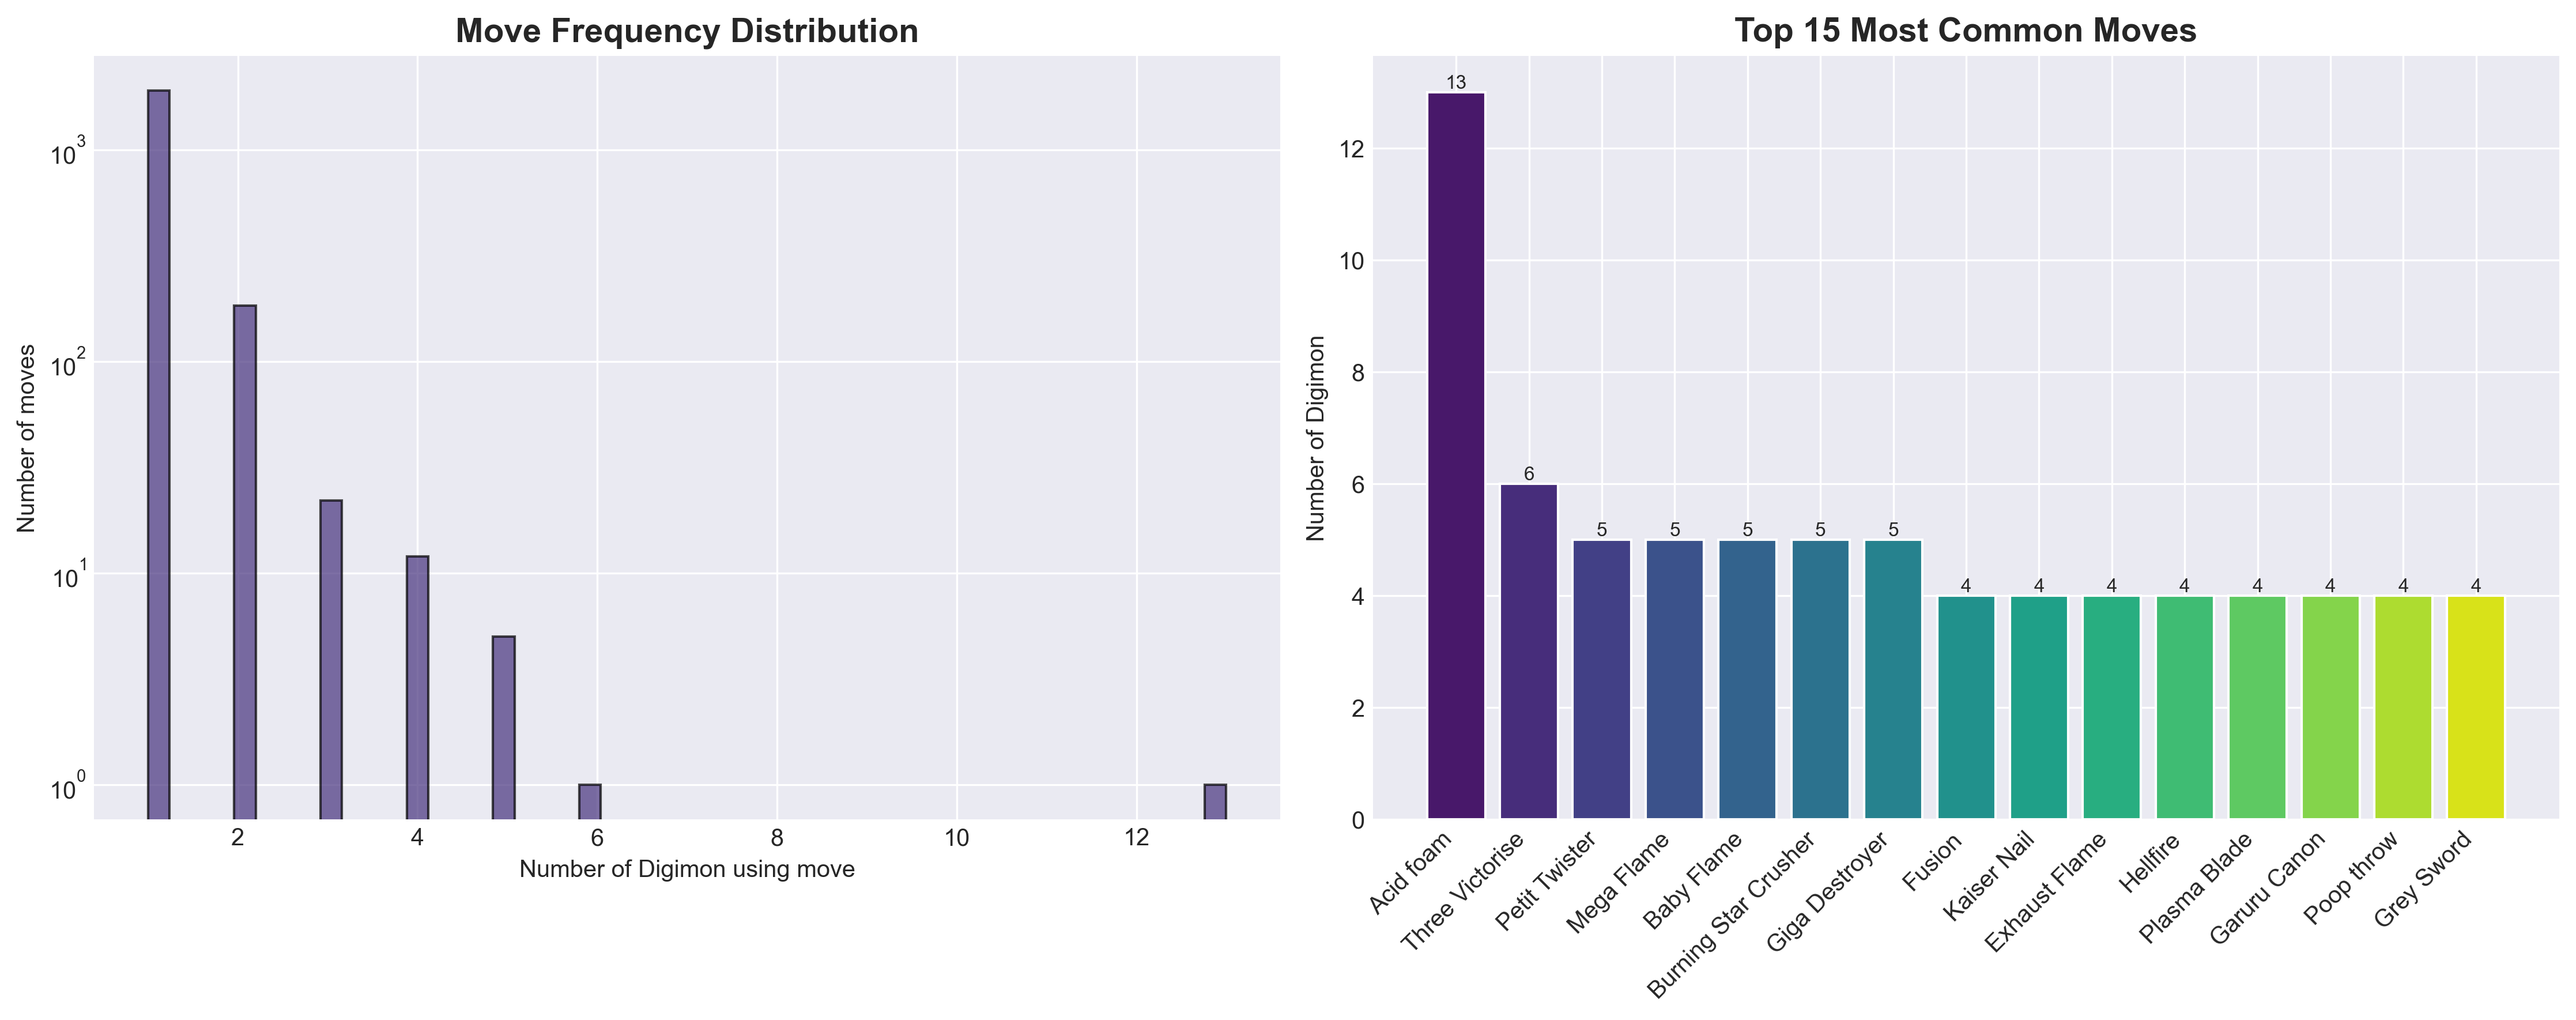

In [38]:
# Move frequency distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of move frequencies
ax1.hist(move_counts.values, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Digimon using move')
ax1.set_ylabel('Number of moves')
ax1.set_title('Move Frequency Distribution', fontsize=14, fontweight='bold')
ax1.set_yscale('log')

# Top moves bar chart
top_moves = move_counts.head(15)
bars = ax2.bar(range(len(top_moves)), top_moves.values, 
                color=sns.color_palette('viridis', len(top_moves)))
ax2.set_xticks(range(len(top_moves)))
ax2.set_xticklabels(top_moves.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Digimon')
ax2.set_title('Top 15 Most Common Moves', fontsize=14, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig, "move_frequency_analysis", notebook_name=notebook_name)
plt.show()

Saved: ../results/04_move_network_analysis/figures/move_complexity_by_level.png
Saved: ../results/04_move_network_analysis/figures/move_complexity_by_level.svg
Saved: ../results/04_move_network_analysis/figures/move_complexity_by_level.pdf


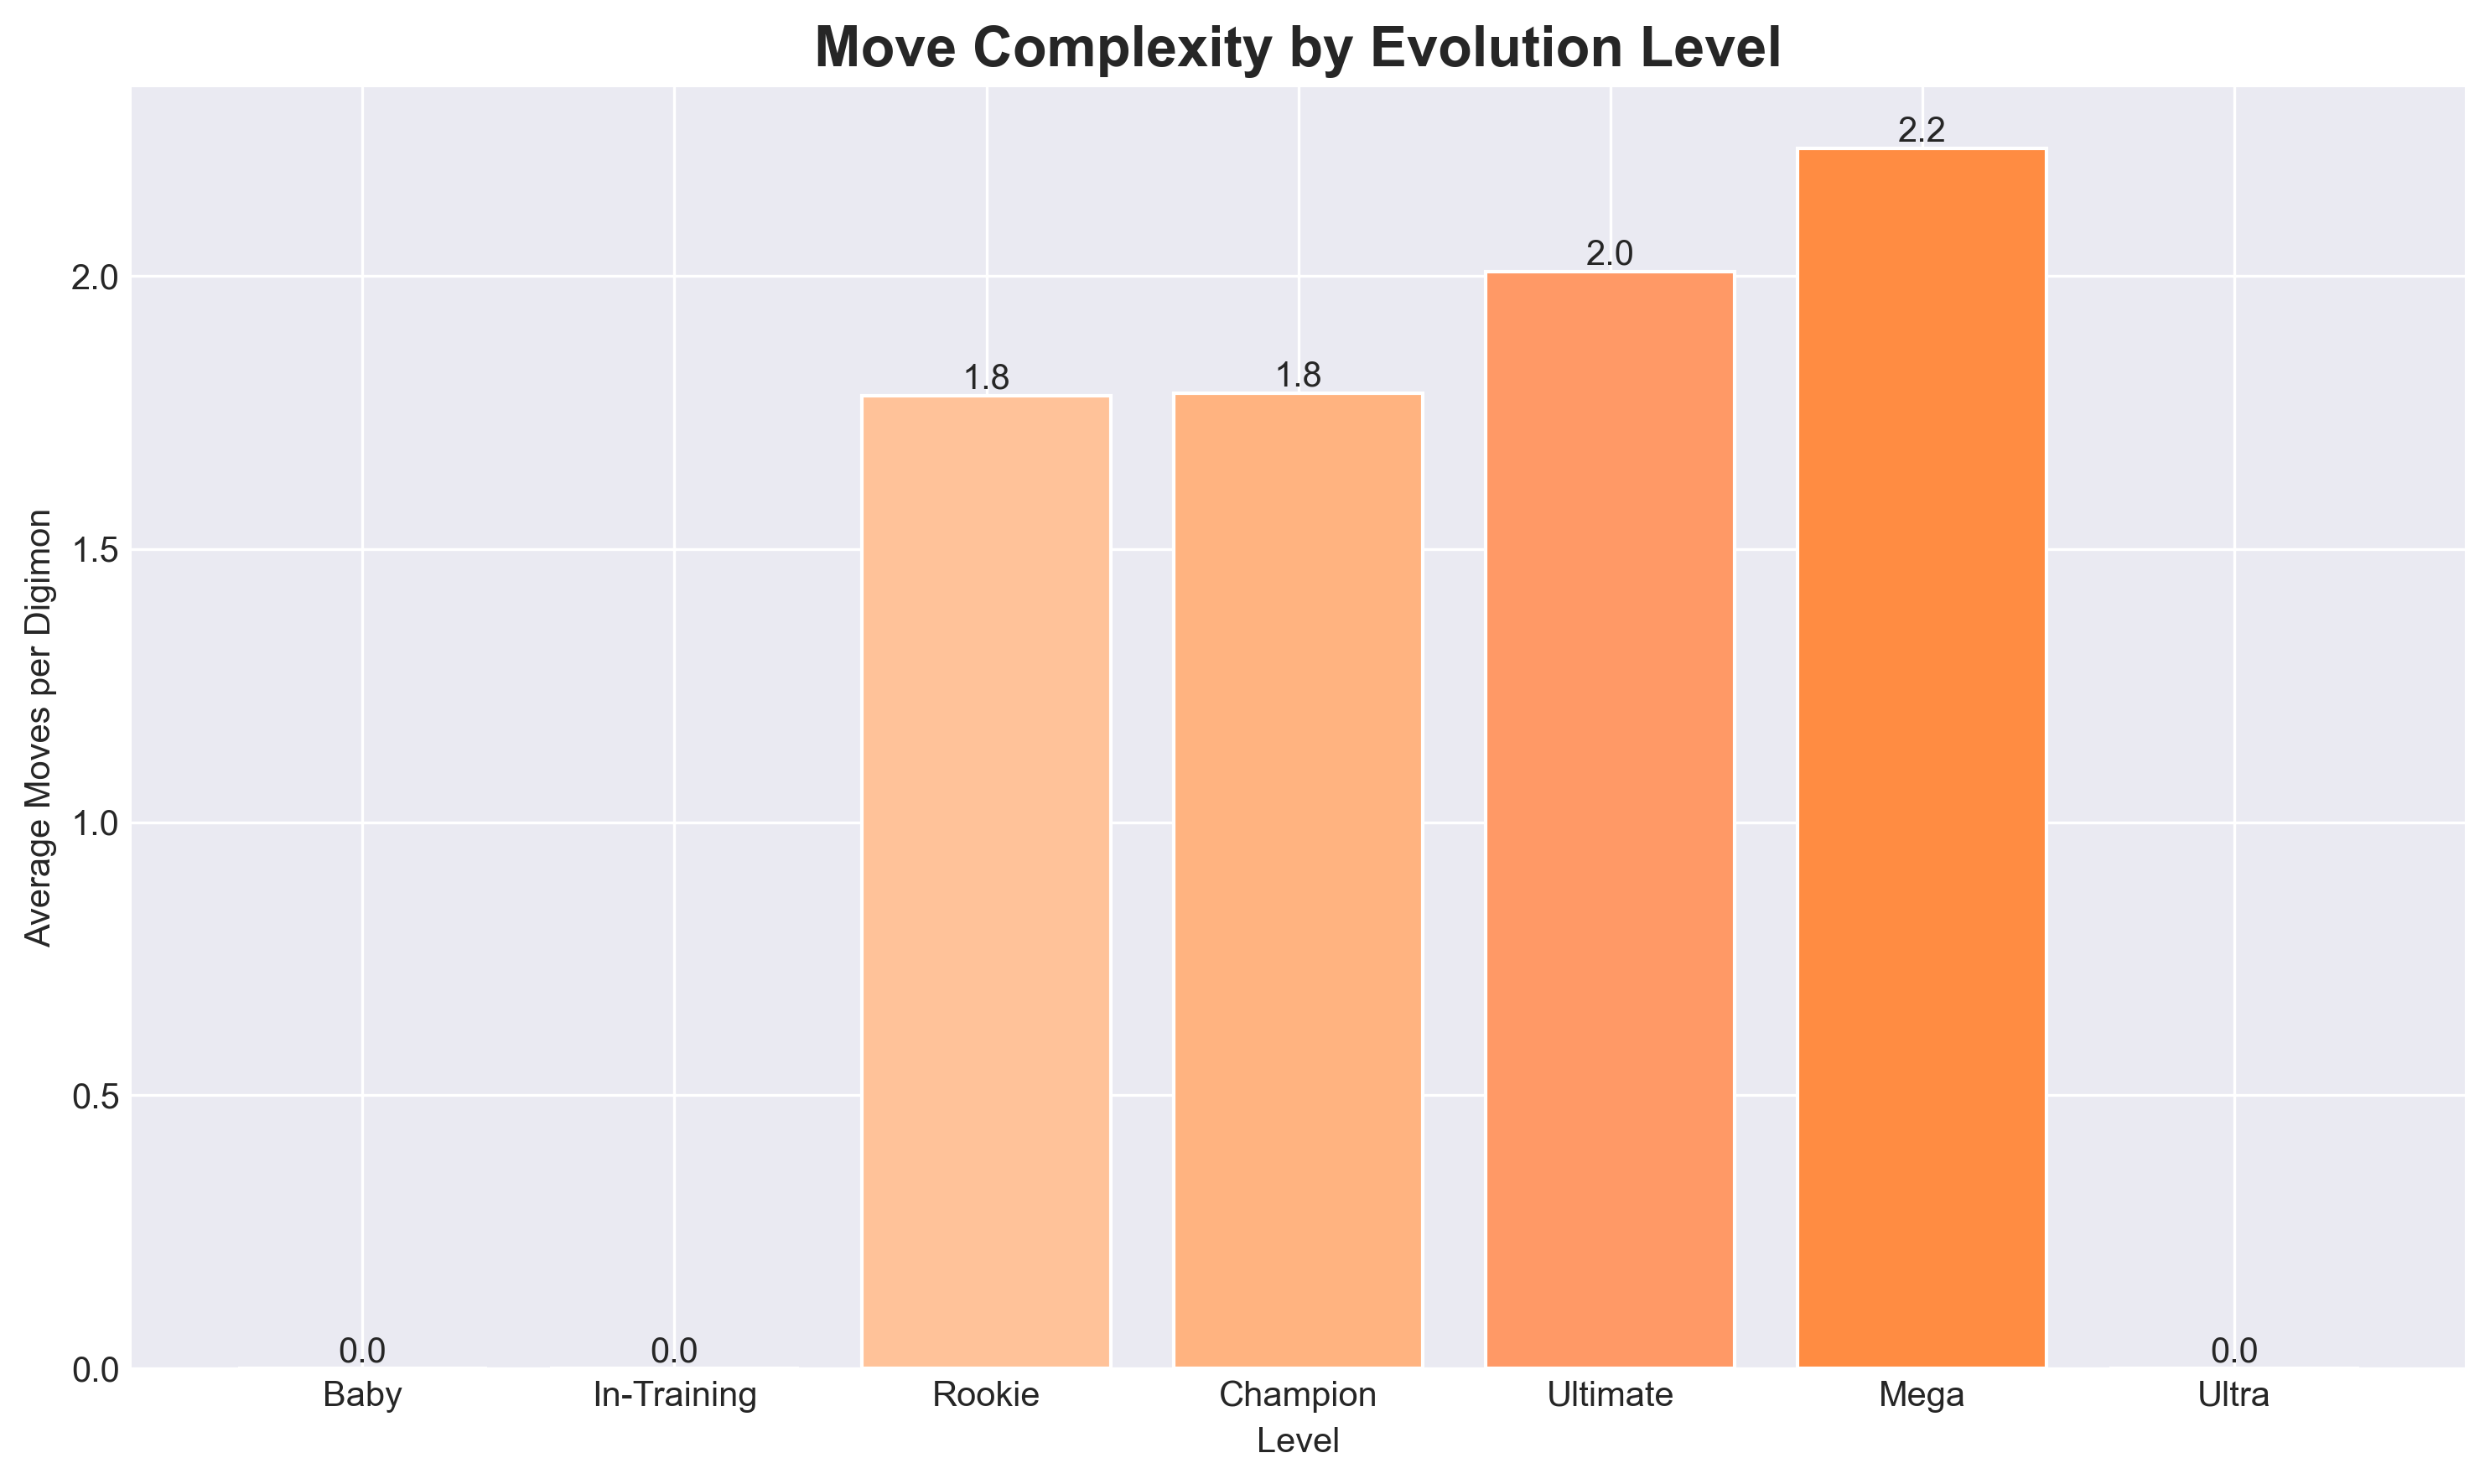

In [39]:
# Move diversity by level visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate average moves per Digimon by level
avg_moves_by_level = moves_with_info.groupby('level')['move'].count() / \
                     moves_with_info.groupby('level')['digimon'].nunique()
avg_moves_by_level = avg_moves_by_level.reindex(level_order, fill_value=0)

colors = [LEVEL_COLORS.get(level, '#808080') for level in level_order]
bars = ax.bar(level_order, avg_moves_by_level.values, color=colors)

ax.set_xlabel('Level')
ax.set_ylabel('Average Moves per Digimon')
ax.set_title('Move Complexity by Evolution Level', fontsize=16, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
save_figure(fig, "move_complexity_by_level", notebook_name=notebook_name)
plt.show()

Saved: ../results/04_move_network_analysis/figures/move_similarity_heatmap.png
Saved: ../results/04_move_network_analysis/figures/move_similarity_heatmap.svg
Saved: ../results/04_move_network_analysis/figures/move_similarity_heatmap.pdf


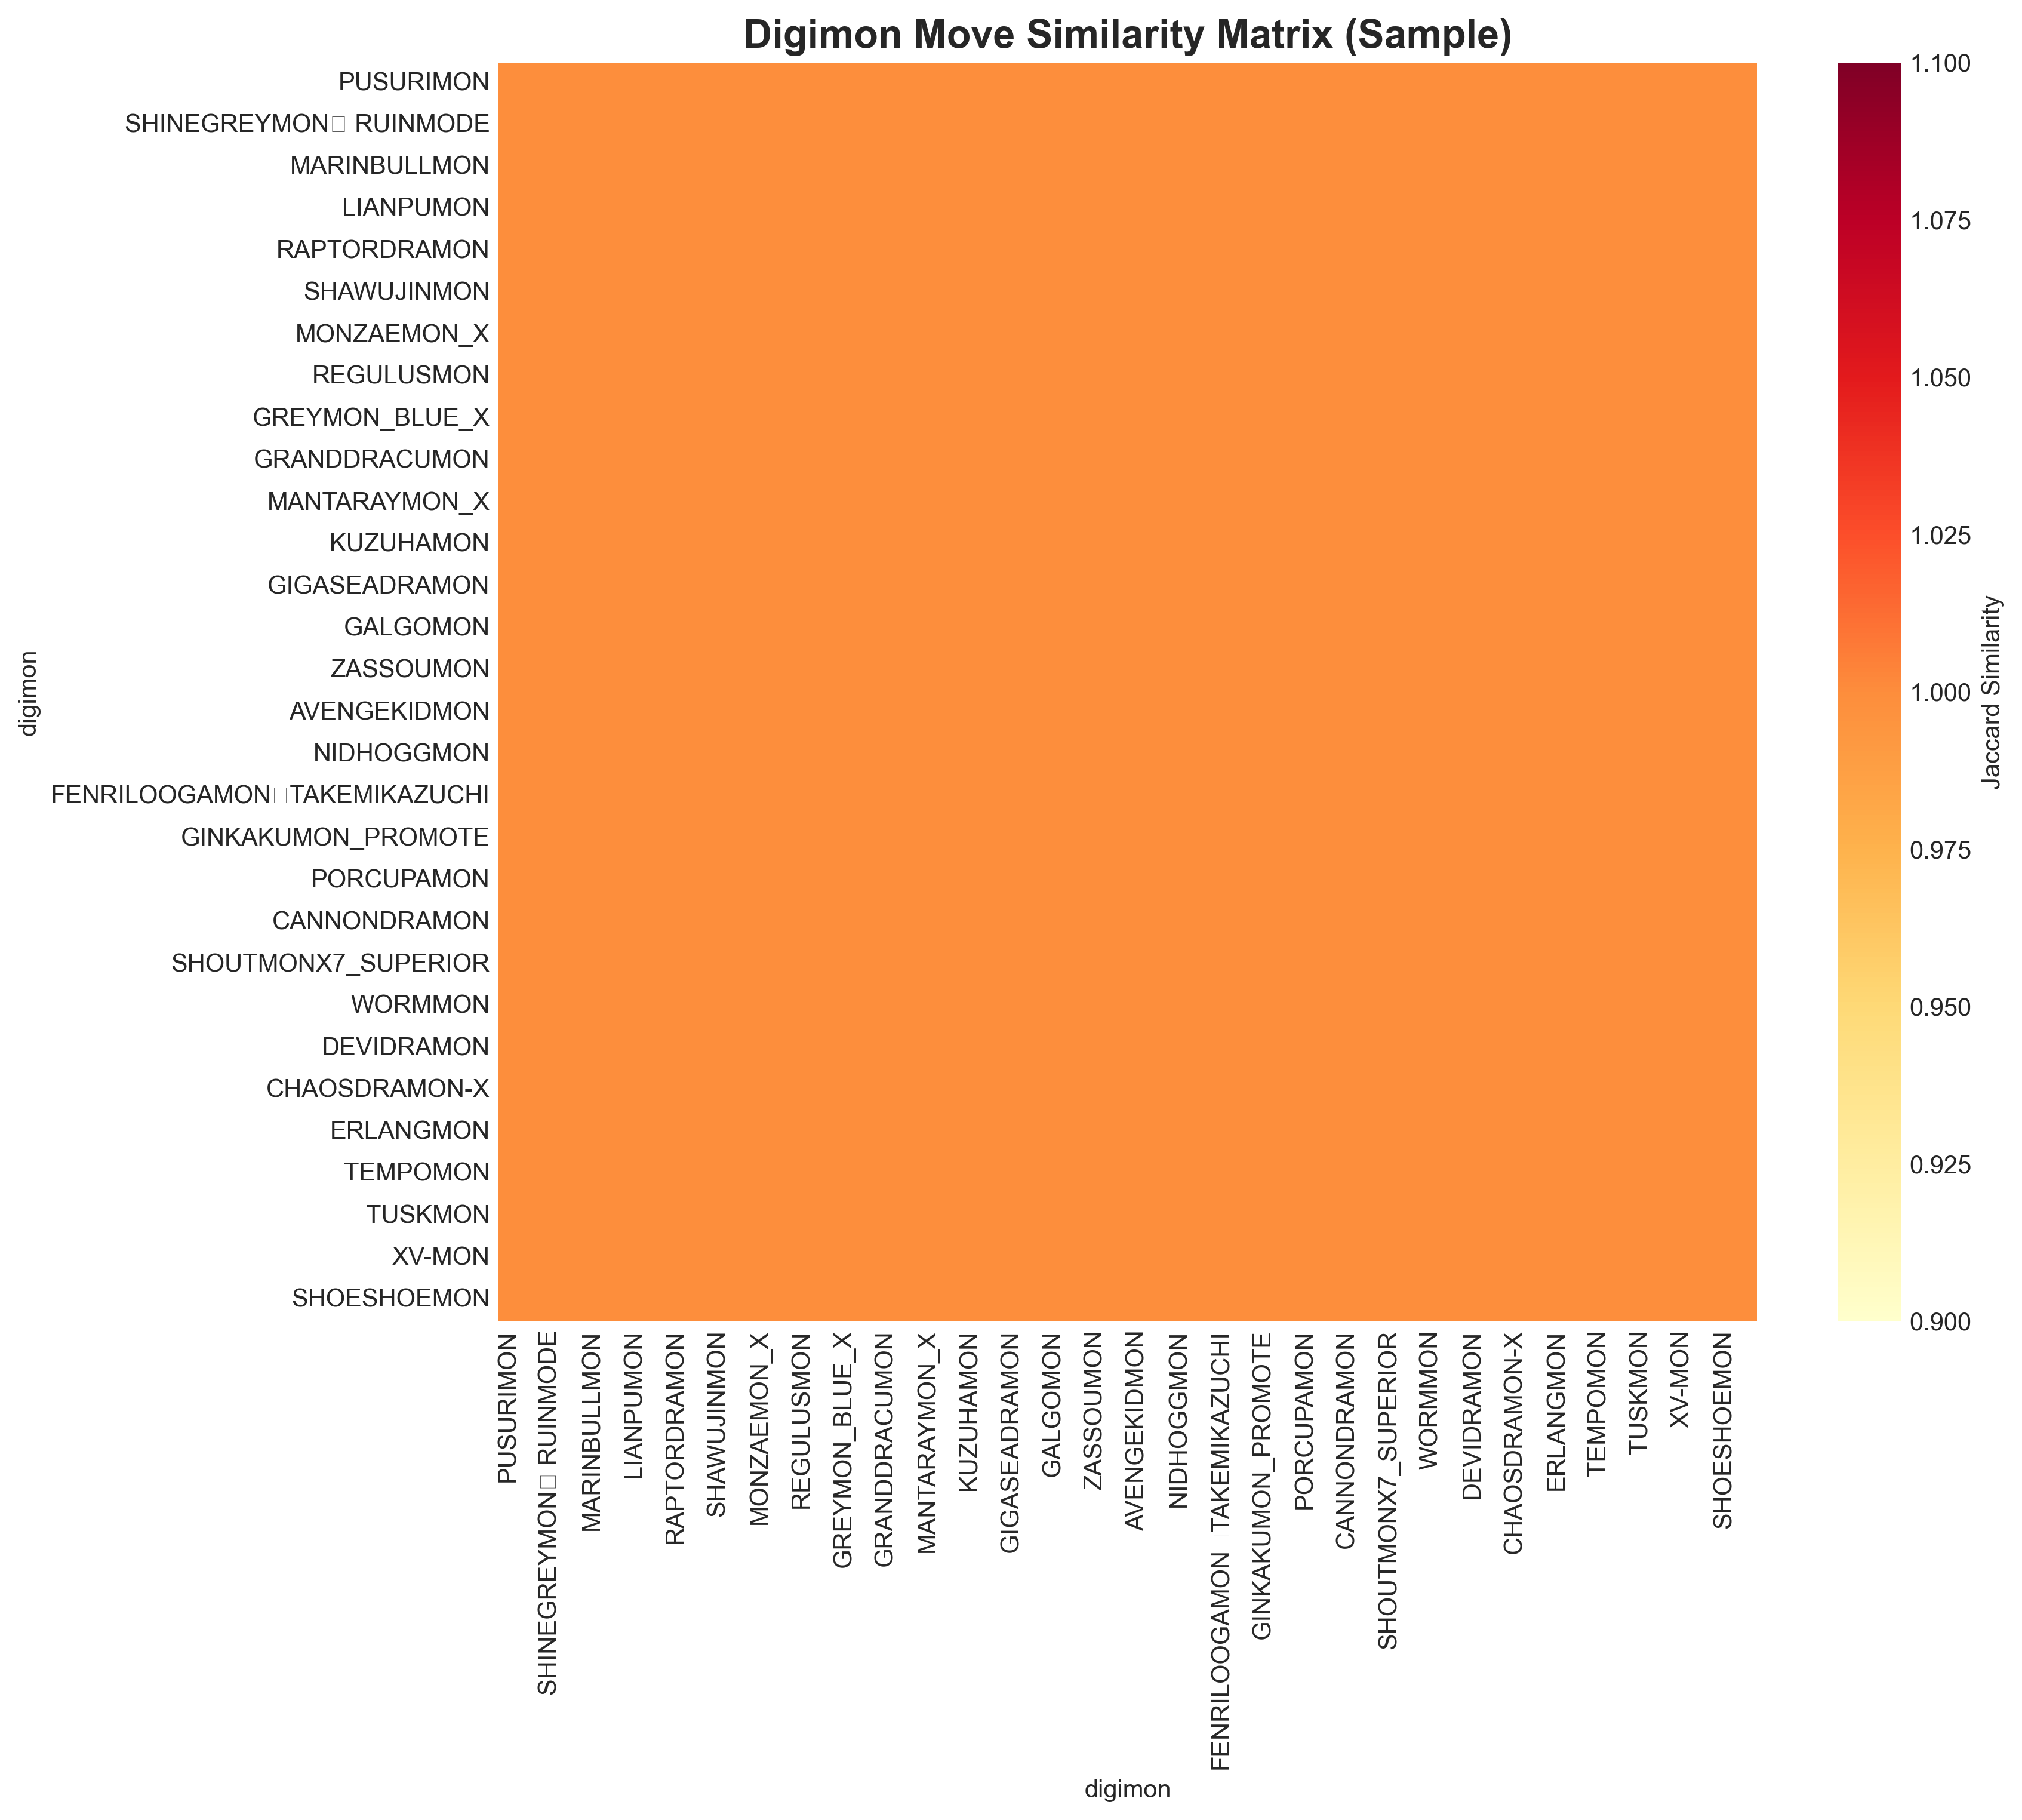

In [40]:
# Move similarity heatmap (sample)
fig, ax = plt.subplots(figsize=(12, 10))

# Sample similarity matrix for visualization
sample_sim = similarity_df.iloc[:30, :30]

sns.heatmap(sample_sim, cmap='YlOrRd', square=True, 
            cbar_kws={'label': 'Jaccard Similarity'},
            xticklabels=True, yticklabels=True, ax=ax)

ax.set_title('Digimon Move Similarity Matrix (Sample)', fontsize=16, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
save_figure(fig, "move_similarity_heatmap", notebook_name=notebook_name)
plt.show()

Saved: ../results/04_move_network_analysis/figures/move_cooccurrence_network.png
Saved: ../results/04_move_network_analysis/figures/move_cooccurrence_network.svg
Saved: ../results/04_move_network_analysis/figures/move_cooccurrence_network.pdf


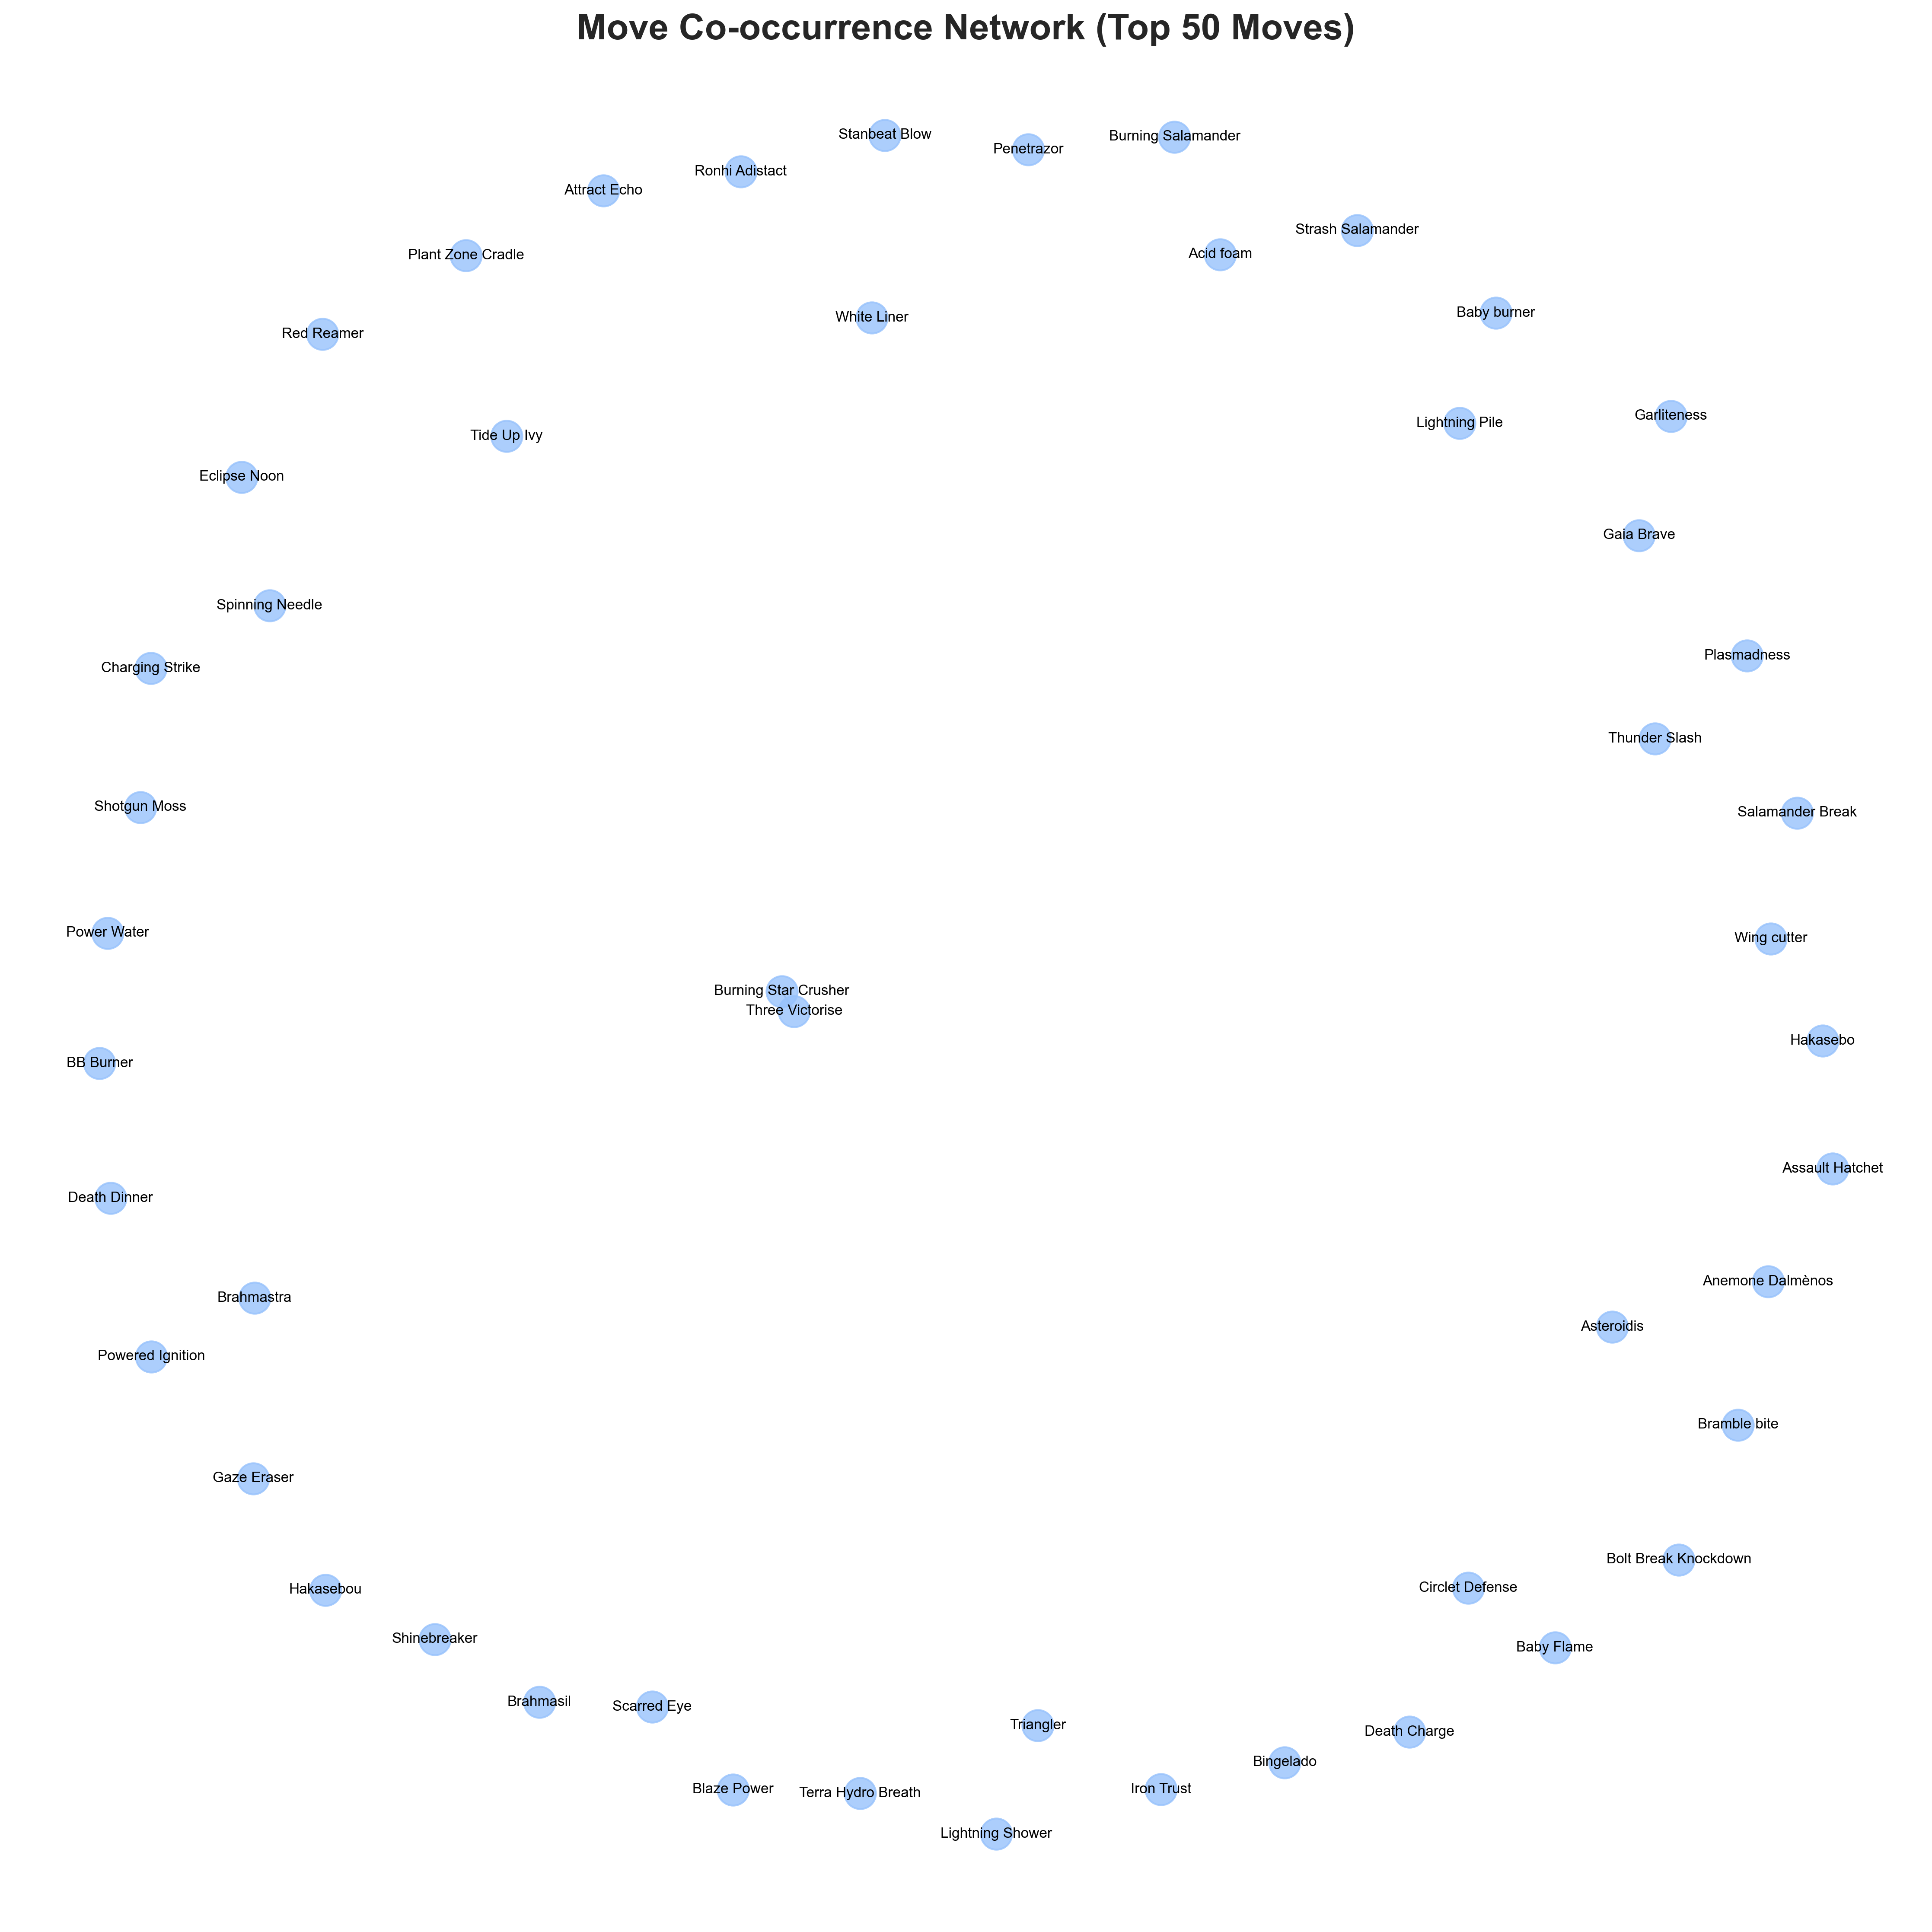

In [41]:
# Move network visualization (subset)
# Create subgraph of most connected moves
top_degree_nodes = [node for node, _ in sorted(degree_centrality.items(), 
                                               key=lambda x: x[1], reverse=True)[:50]]
move_subgraph = move_network.subgraph(top_degree_nodes).copy()

# Create visualization
fig = plot_network_static(
    move_subgraph,
    title="Move Co-occurrence Network (Top 50 Moves)",
    layout='spring',
    figsize=(15, 15)
)
save_figure(fig, "move_cooccurrence_network", notebook_name=notebook_name)
plt.show()

Saved: ../results/04_move_network_analysis/figures/move_evolution_analysis.png
Saved: ../results/04_move_network_analysis/figures/move_evolution_analysis.svg
Saved: ../results/04_move_network_analysis/figures/move_evolution_analysis.pdf


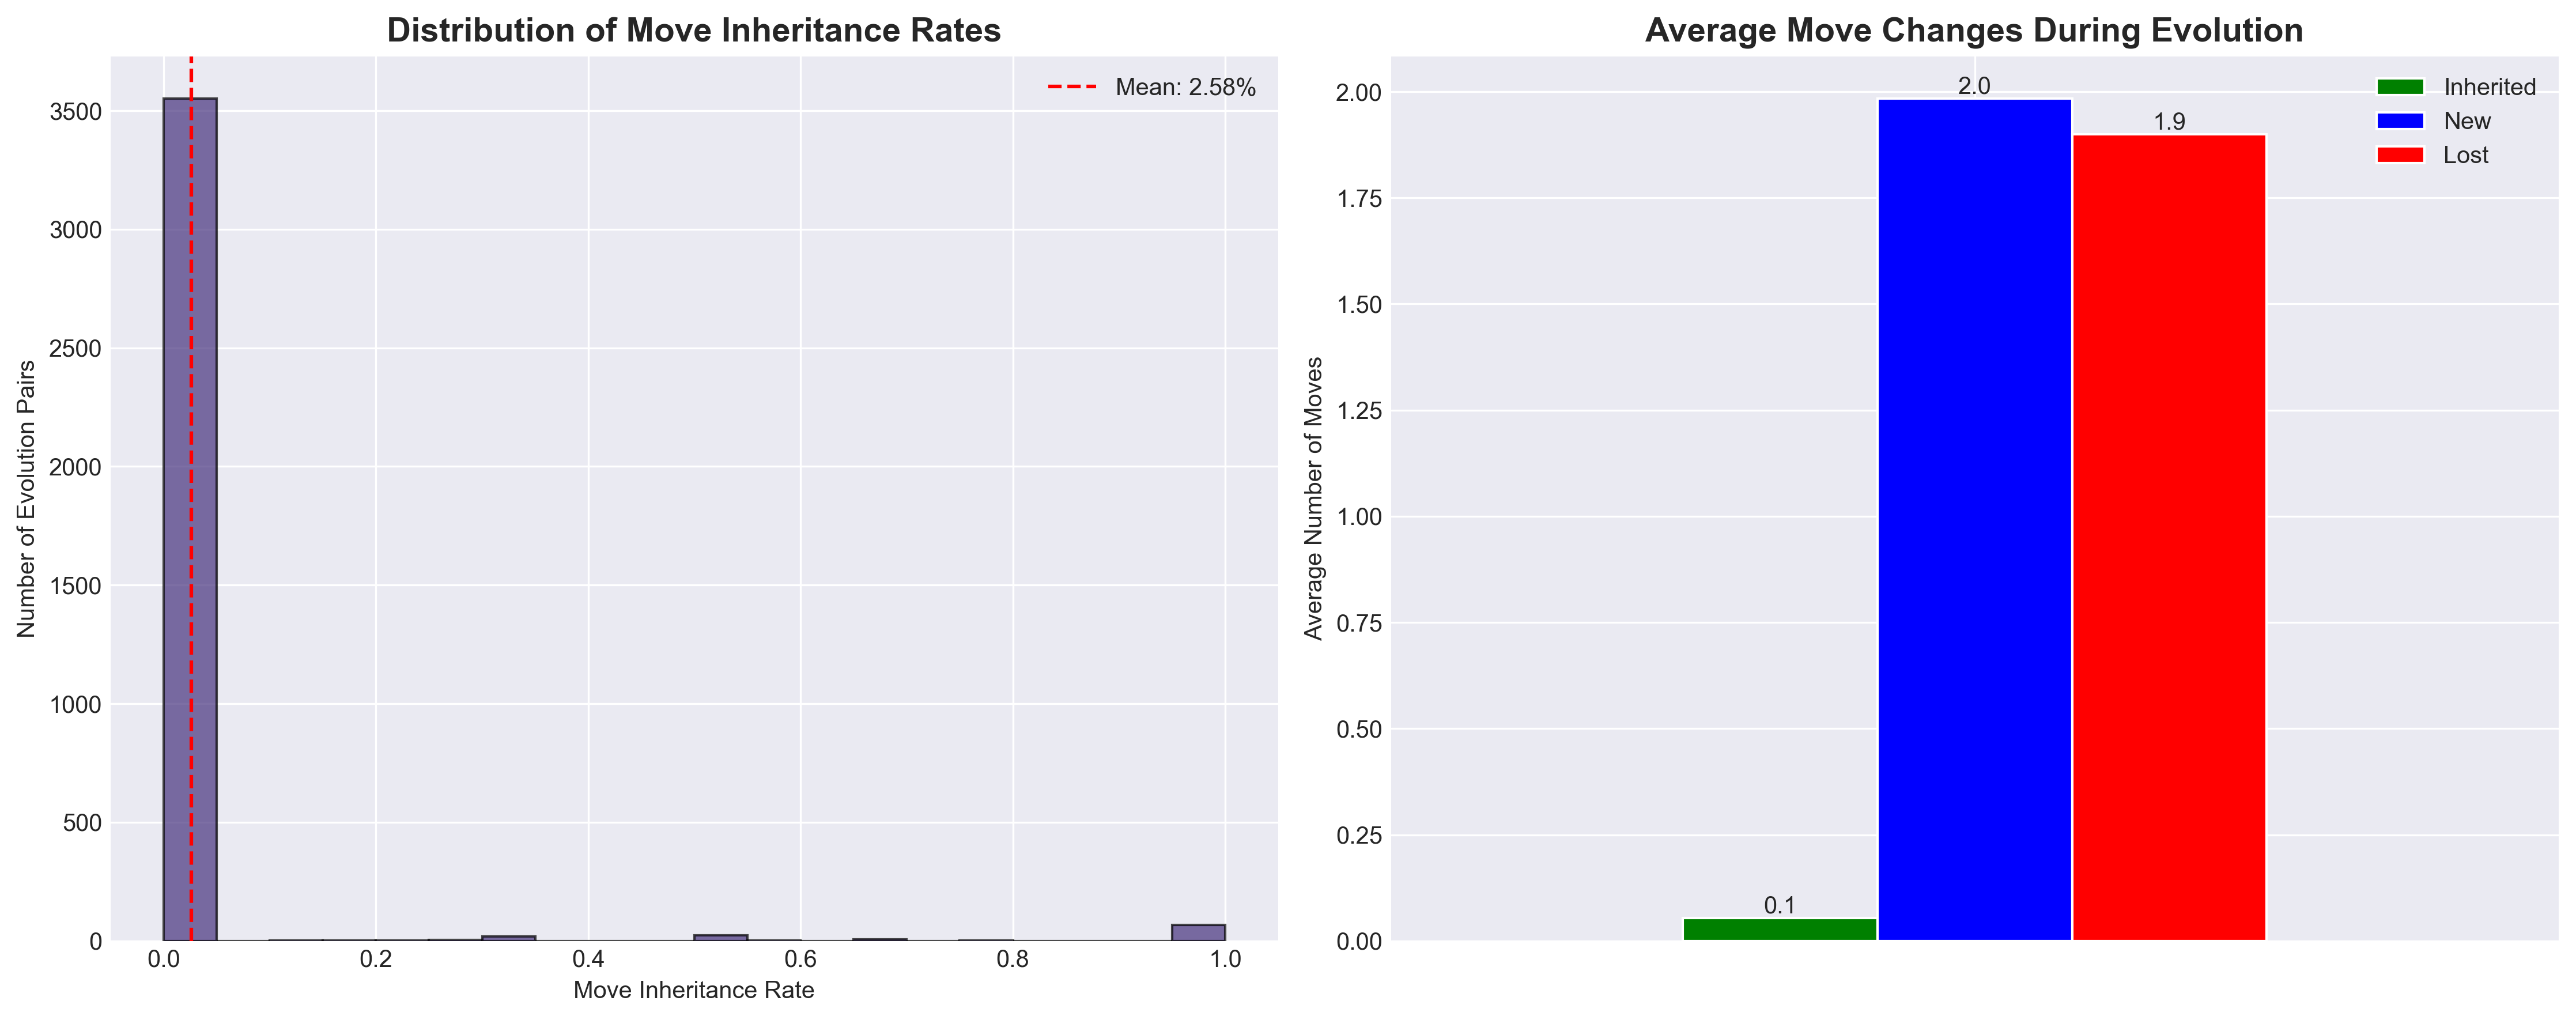

In [42]:
# Move inheritance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Inheritance rate distribution
ax1.hist(inheritance_df['inheritance_rate'], bins=20, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Move Inheritance Rate')
ax1.set_ylabel('Number of Evolution Pairs')
ax1.set_title('Distribution of Move Inheritance Rates', fontsize=14, fontweight='bold')
ax1.axvline(inheritance_df['inheritance_rate'].mean(), color='red', 
           linestyle='--', label=f'Mean: {inheritance_df["inheritance_rate"].mean():.2%}')
ax1.legend()

# Move changes during evolution
evolution_changes = pd.DataFrame({
    'Inherited': inheritance_df['inherited_moves'].mean(),
    'New': inheritance_df['new_moves'].mean(),
    'Lost': inheritance_df['lost_moves'].mean()
}, index=['Moves'])

evolution_changes.plot(kind='bar', ax=ax2, color=['green', 'blue', 'red'])
ax2.set_ylabel('Average Number of Moves')
ax2.set_title('Average Move Changes During Evolution', fontsize=14, fontweight='bold')
ax2.set_xticklabels([''], rotation=0)
ax2.legend(loc='upper right')

# Add value labels
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f')

plt.tight_layout()
save_figure(fig, "move_evolution_analysis", notebook_name=notebook_name)
plt.show()

## 8. Export Results

In [43]:
# Create results directory
from pathlib import Path
import json

results_dir = Path(f'../results/{notebook_name}/data')
results_dir.mkdir(parents=True, exist_ok=True)

# Prepare move statistics
move_statistics = {
    'total_unique_moves': int(moves_df['move'].nunique()),
    'total_digimon_with_moves': int(moves_df['digimon'].nunique()),
    'total_move_relationships': len(moves_df),
    'avg_moves_per_digimon': float(digimon_move_counts.mean()),
    'max_moves_per_digimon': int(digimon_move_counts.max()),
    'most_common_move': move_counts.index[0],
    'rare_moves_count': int((move_counts == 1).sum()),
    'avg_move_inheritance_rate': float(inheritance_df['inheritance_rate'].mean()),
    'move_network_density': float(network_metrics['density']),
    'move_network_components': int(network_metrics['num_components'])
}

# Save statistics
with open(results_dir / 'move_statistics.json', 'w') as f:
    json.dump(move_statistics, f, indent=2)

# Save move frequency data
move_counts.to_frame('count').reset_index().rename(columns={'index': 'move'}).to_csv(
    results_dir / 'move_frequencies.csv', index=False
)

# Save inheritance analysis
inheritance_df.to_csv(results_dir / 'move_inheritance_analysis.csv', index=False)

# Save cluster assignments
cluster_df.to_csv(results_dir / 'move_based_clusters.csv', index=False)

# Save central moves
central_moves_df = pd.DataFrame({
    'move': [m for m, _ in top_degree_moves],
    'degree_centrality': [c for _, c in top_degree_moves],
    'betweenness_centrality': [betweenness_centrality.get(m, 0) for m, _ in top_degree_moves]
})
central_moves_df.to_csv(results_dir / 'central_moves.csv', index=False)

print("Move analysis results exported successfully!")

Move analysis results exported successfully!


## Summary and Key Findings

### Move Network Insights:

1. **Move Distribution**:
   - Wide variety of moves with heavy-tailed distribution
   - Most moves are unique or used by few Digimon
   - Some universal moves appear across many Digimon

2. **Move-based Similarity**:
   - Digimon cluster into groups based on shared movesets
   - Move similarity often correlates with type/level
   - Certain move combinations frequently co-occur

3. **Evolution Patterns**:
   - Moderate move inheritance through evolution
   - Evolution typically adds new moves while retaining some core moves
   - Signature moves persist through evolution chains

4. **Network Structure**:
   - Move co-occurrence network shows community structure
   - Central moves act as bridges between different move groups
   - Cliques reveal standard move combinations

These insights reveal the complexity of the move system and how it relates to Digimon identity and evolution.

In [44]:
# Close database connection
conn.close()
print("Move network analysis complete! Database connection closed.")

Move network analysis complete! Database connection closed.
